Epoch 1/20, Train Loss: -0.3266, Val Loss: -0.7024
Epoch 2/20, Train Loss: -1.0684, Val Loss: -1.4396
Epoch 3/20, Train Loss: -1.8025, Val Loss: -2.1580
Epoch 4/20, Train Loss: -2.5083, Val Loss: -2.8040
Epoch 5/20, Train Loss: -3.1114, Val Loss: -3.2232
Epoch 6/20, Train Loss: -3.4796, Val Loss: -3.3128
Epoch 7/20, Train Loss: -3.5970, Val Loss: -3.2397
Epoch 8/20, Train Loss: -3.6058, Val Loss: -3.2475
Epoch 9/20, Train Loss: -3.6116, Val Loss: -3.2397
Epoch 10/20, Train Loss: -3.6179, Val Loss: -3.2399
Epoch 11/20, Train Loss: -3.6118, Val Loss: -3.2441
Epoch 12/20, Train Loss: -3.6181, Val Loss: -3.2306
Epoch 13/20, Train Loss: -3.6155, Val Loss: -3.2021
Epoch 14/20, Train Loss: -3.6123, Val Loss: -3.2437
Epoch 15/20, Train Loss: -3.6184, Val Loss: -3.2410
Epoch 16/20, Train Loss: -3.6254, Val Loss: -3.2266
Epoch 17/20, Train Loss: -3.6149, Val Loss: -3.2367
Epoch 18/20, Train Loss: -3.6161, Val Loss: -3.2315
Epoch 19/20, Train Loss: -3.6204, Val Loss: -3.2212
Epoch 20/20, Train Lo

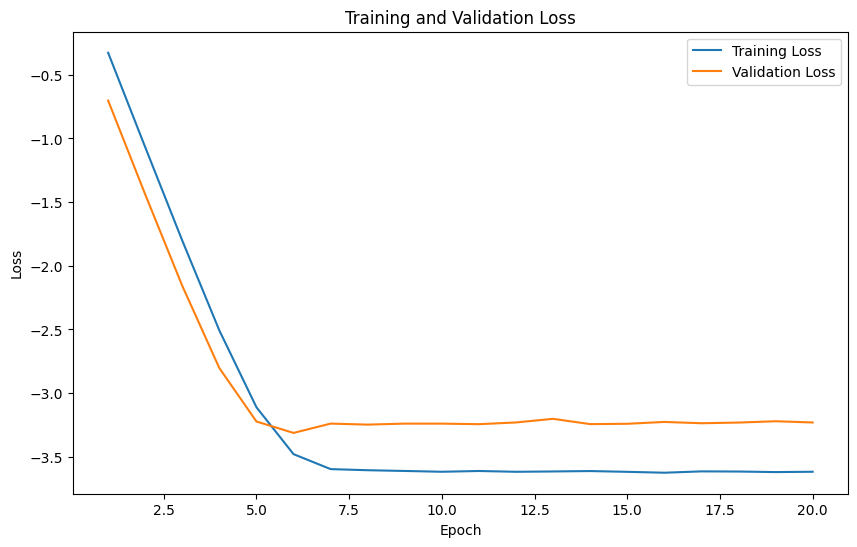

Test Loss: -3.1180


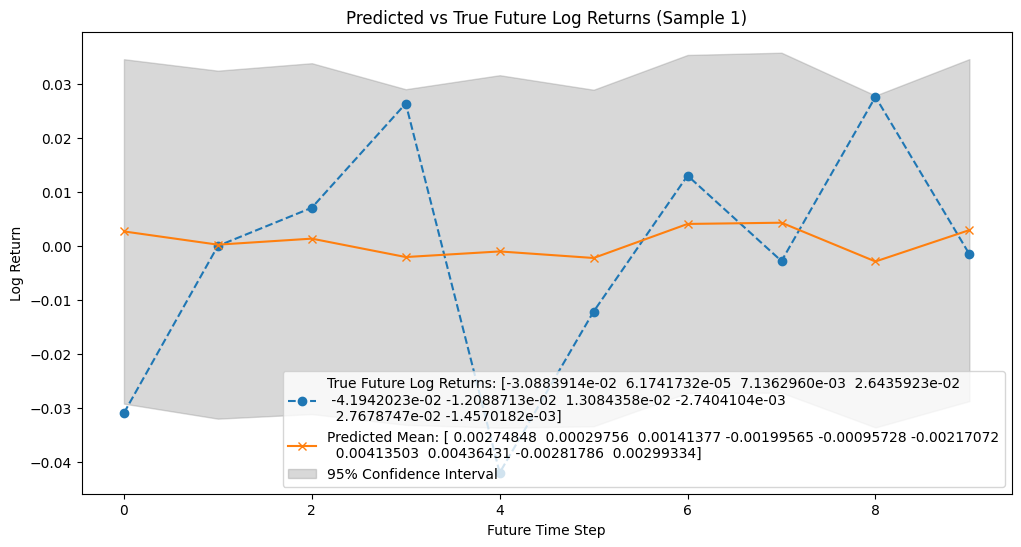

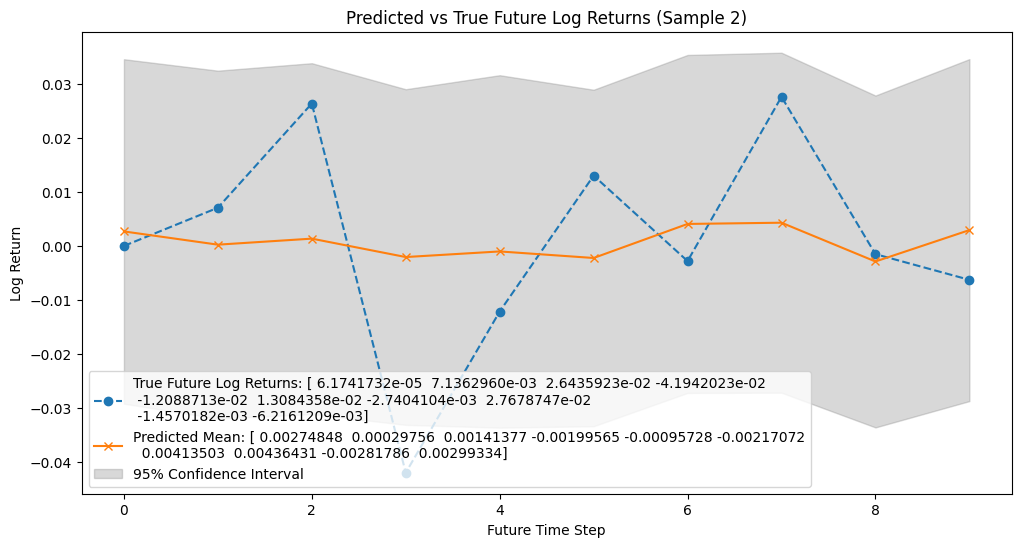

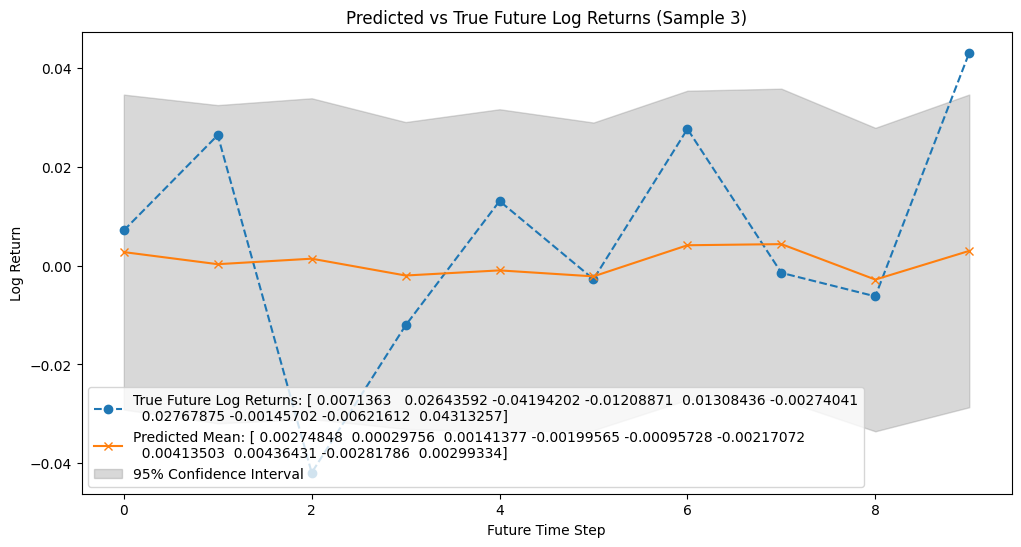

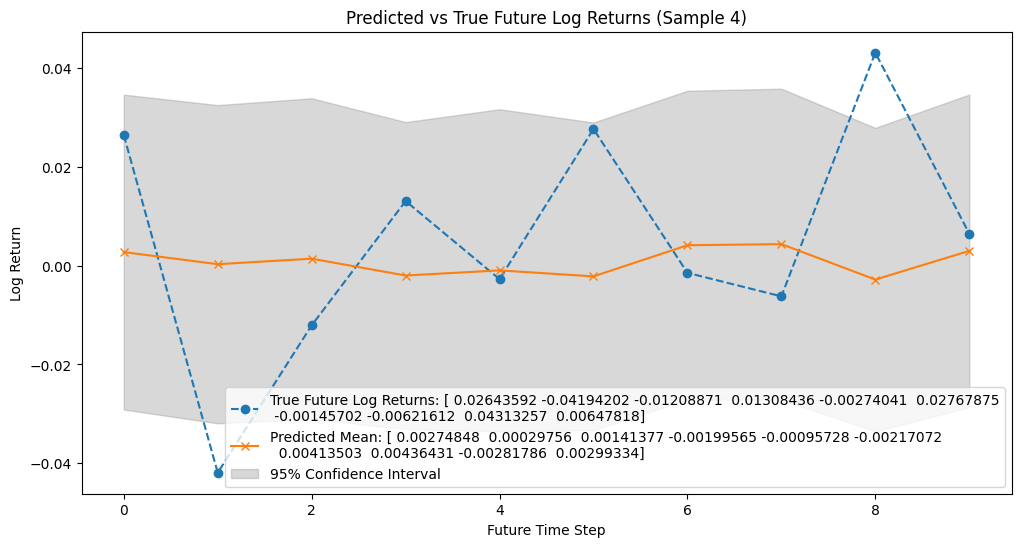

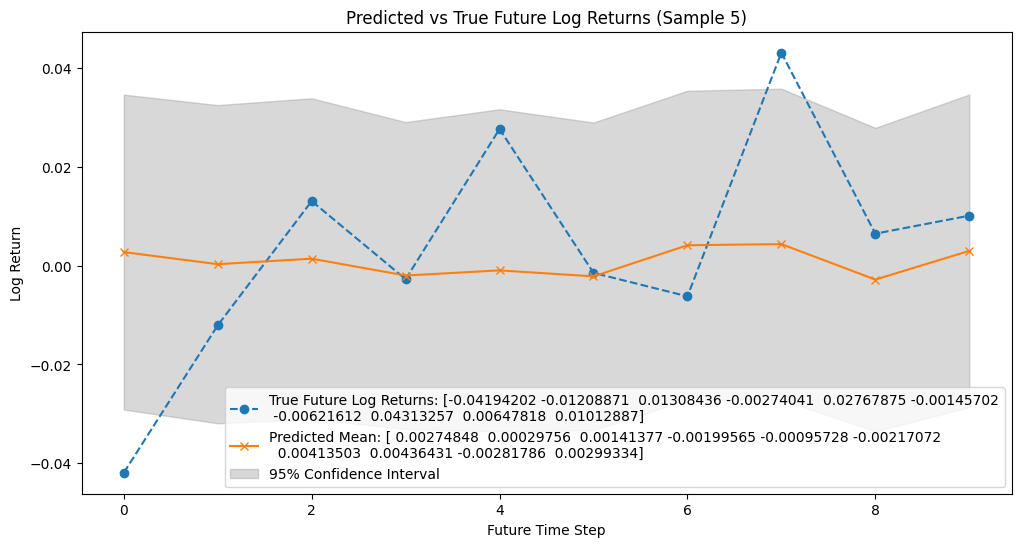

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Step 1: Read and Preprocess Data
file_path = 'cache/TGT_max_1day_data.csv'  # Path to your CSV file

# Read CSV
df = pd.read_csv(file_path)

# Compute log returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()  # Remove rows with NaN values (first row)

# Prepare features and targets
sequence_length = 20  # Historical window
forecast_horizon = 10  # Future prediction window

features = []
targets = []

for i in range(len(df) - sequence_length - forecast_horizon):
    # Extract historical window of log returns and volume
    historical = df.iloc[i:i+sequence_length]
    features.append(historical[['log_return', 'volume']].values)

    # Extract future log returns
    future = df.iloc[i+sequence_length:i+sequence_length+forecast_horizon]
    targets.append(future['log_return'].values)

features = np.array(features)  # Shape: (num_samples, sequence_length, 2)
targets = np.array(targets)  # Shape: (num_samples, forecast_horizon)

# Step 2: Dataset Class
class LogReturnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split into train (70%), validation (15%), and test (15%) sets
train_size = int(0.7 * len(features))
val_size = int(0.15 * len(features))
test_size = len(features) - train_size - val_size

train_dataset = LogReturnDataset(features[:train_size], targets[:train_size])
val_dataset = LogReturnDataset(
    features[train_size:train_size + val_size], targets[train_size:train_size + val_size]
)
test_dataset = LogReturnDataset(features[train_size + val_size:], targets[train_size + val_size:])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 3: Define the Model
class LogReturnPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_length):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_length)  # Predict mean sequence
        self.fc_sigma = nn.Linear(hidden_dim, output_length)  # Predict log variance sequence

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output
        h_last = lstm_out[:, -1, :]  # Use the last hidden state
        mu = self.fc_mu(h_last)  # Predicted mean sequence
        log_sigma = self.fc_sigma(h_last)  # Predicted log variance sequence
        sigma = torch.exp(log_sigma)  # Ensure positivity for standard deviation
        return mu, sigma

# Step 4: Define Loss Function
def negative_log_likelihood(mu, sigma, target):
    nll = torch.log(sigma) + 0.5 * ((target - mu) ** 2) / (sigma ** 2)
    return nll.mean()

# Step 5: Training and Validation Loop
# Initialize model, optimizer, and device
input_dim = 2  # Log returns and volume
hidden_dim = 50
output_length = forecast_horizon
model = LogReturnPredictor(input_dim, hidden_dim, output_length)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        mu, sigma = model(batch_X)
        loss = negative_log_likelihood(mu, sigma, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            mu, sigma = model(batch_X)
            loss = negative_log_likelihood(mu, sigma, batch_y)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Step 6: Plot Losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Step 7: Evaluate Test Loss
def evaluate_test_loss(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # No gradient computation
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            mu, sigma = model(batch_X)  # Get predictions
            loss = negative_log_likelihood(mu, sigma, batch_y)  # Compute NLL loss
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)
    return average_loss

# Evaluate test loss
# Comparison with Training and Validation Loss:
	# •	Test loss ≈ Validation loss:
	# •	Good generalization. The model is performing similarly on unseen data as it did on validation data.
	# •	Test loss > Validation loss:
	# •	Indicates the model is overfitting the training data. You might need more regularization, dropout, or additional training data.
test_loss = evaluate_test_loss(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

# Step 8: Visualize Predictions
batch_X, batch_y = next(iter(test_loader))
batch_X, batch_y = batch_X.to(device), batch_y.to(device)

with torch.no_grad():
    mu, sigma = model(batch_X)

# Convert to NumPy for visualization
batch_X = batch_X.cpu().numpy()
batch_y = batch_y.cpu().numpy()
mu = mu.cpu().numpy()
sigma = sigma.cpu().numpy()

# Plot predictions for first sequence in batch
for i in range(5):
    plt.figure(figsize=(12, 6))
    plt.plot(batch_y[i], label=f"True Future Log Returns: {batch_y[i]}", linestyle="--", marker="o")
    plt.plot(mu[i], label=f"Predicted Mean: {mu[i]}", linestyle="-", marker="x")
    plt.fill_between(
        range(len(mu[i])),
        mu[i] - 1.96 * sigma[i],
        mu[i] + 1.96 * sigma[i],
        color='gray',
        alpha=0.3,
        label="95% Confidence Interval",
    )
    


    plt.title(f"Predicted vs True Future Log Returns (Sample {i+1})")
    plt.xlabel("Future Time Step")
    plt.ylabel("Log Return")
    plt.legend()
    plt.show()